In [ ]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from pytz import timezone

In [ ]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = 32
NUM_CLASSES = 10

In [ ]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            _, probabilities = model(images)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [ ]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [ ]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits, _ = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [ ]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits, _ = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):

        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
# LeNet5 모델 정의
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )

        self.dropout = nn.Dropout(p=0.5)  # 드롭아웃 추가

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor[0](x)  # 첫 번째 컨볼루션 레이어
        x = self.feature_extractor[1](x)  # 활성화 함수
        x = self.feature_extractor[2](x)  # 풀링 레이어
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.feature_extractor[3](x)  # 두 번째 컨볼루션 레이어
        x = self.feature_extractor[4](x)  # 활성화 함수
        x = self.feature_extractor[5](x)  # 풀링 레이어
        x = self.feature_extractor[6](x)  # 세 번째 컨볼루션 레이어
        x = self.feature_extractor[7](x)  # 활성화 함수

        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15943985.22it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 474158.70it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4439584.43it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2046683.37it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Train dataset size: 60000
Validation dataset size: 10000


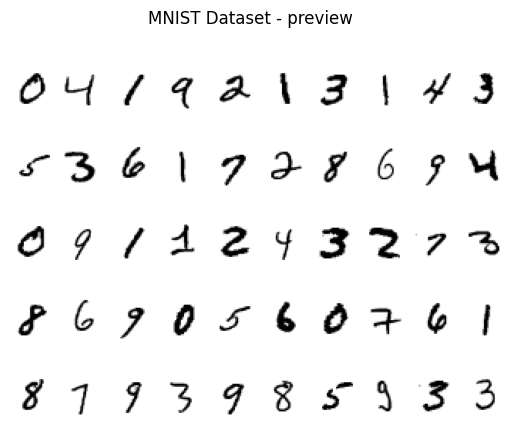

In [ ]:
# transforms 정의하기
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# 데이터셋 다운로드 및 생성
train_dataset = datasets.MNIST(
    root="mnist_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.MNIST(root="mnist_data", train=False, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 불러온 MNIST 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    plt.imshow(train_dataset.data[index], cmap="gray_r")
fig.suptitle("MNIST Dataset - preview")

# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")  # Train dataset size: 60000
print(
    f"Validation dataset size: {len(valid_dataset)}"
)  # Validation dataset size: 10000

22:31:22 ---  Epoch: 0	Train loss: 2.2943	Valid loss: 2.2762	Train accuracy: 24.03	Valid accuracy: 24.17
22:31:50 ---  Epoch: 1	Train loss: 2.2460	Valid loss: 2.1879	Train accuracy: 53.13	Valid accuracy: 54.41
22:32:18 ---  Epoch: 2	Train loss: 2.0428	Valid loss: 1.7734	Train accuracy: 61.01	Valid accuracy: 62.01
22:32:46 ---  Epoch: 3	Train loss: 1.4927	Valid loss: 1.1659	Train accuracy: 71.06	Valid accuracy: 72.02
22:33:15 ---  Epoch: 4	Train loss: 1.0239	Valid loss: 0.8282	Train accuracy: 79.04	Valid accuracy: 79.76
22:33:42 ---  Epoch: 5	Train loss: 0.7840	Valid loss: 0.6598	Train accuracy: 82.58	Valid accuracy: 83.41
22:34:11 ---  Epoch: 6	Train loss: 0.6553	Valid loss: 0.5604	Train accuracy: 84.74	Valid accuracy: 85.44
22:34:39 ---  Epoch: 7	Train loss: 0.5762	Valid loss: 0.4952	Train accuracy: 86.21	Valid accuracy: 86.93
22:35:07 ---  Epoch: 8	Train loss: 0.5225	Valid loss: 0.4487	Train accuracy: 87.25	Valid accuracy: 88.04
22:35:36 ---  Epoch: 9	Train loss: 0.4816	Valid loss: 0

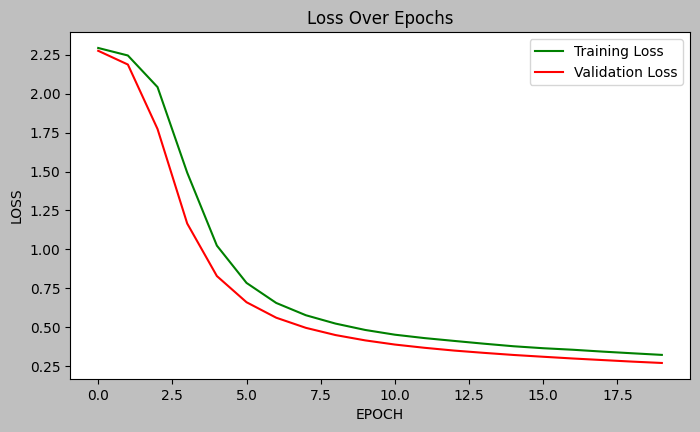

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

22:19:13 ---  Epoch: 0	Train loss: 0.2731	Valid loss: 0.1010	Train accuracy: 96.87	Valid accuracy: 96.82
22:19:41 ---  Epoch: 1	Train loss: 0.1079	Valid loss: 0.0729	Train accuracy: 98.08	Valid accuracy: 97.71
22:20:10 ---  Epoch: 2	Train loss: 0.0823	Valid loss: 0.0574	Train accuracy: 98.43	Valid accuracy: 98.19
22:20:38 ---  Epoch: 3	Train loss: 0.0702	Valid loss: 0.0525	Train accuracy: 98.80	Valid accuracy: 98.40
22:21:06 ---  Epoch: 4	Train loss: 0.0598	Valid loss: 0.0432	Train accuracy: 99.06	Valid accuracy: 98.62
22:21:35 ---  Epoch: 5	Train loss: 0.0564	Valid loss: 0.0442	Train accuracy: 99.14	Valid accuracy: 98.54
22:22:04 ---  Epoch: 6	Train loss: 0.0510	Valid loss: 0.0485	Train accuracy: 99.01	Valid accuracy: 98.49
22:22:32 ---  Epoch: 7	Train loss: 0.0482	Valid loss: 0.0452	Train accuracy: 99.23	Valid accuracy: 98.56
22:23:01 ---  Epoch: 8	Train loss: 0.0458	Valid loss: 0.0537	Train accuracy: 99.11	Valid accuracy: 98.38
22:23:29 ---  Epoch: 9	Train loss: 0.0406	Valid loss: 0

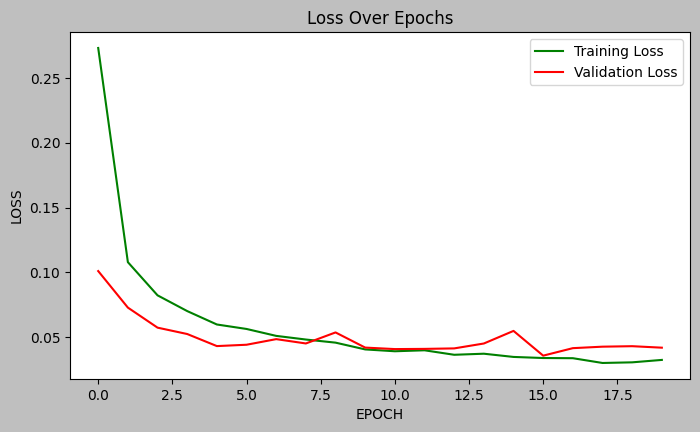

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)